## Background
The Pajaro Valley Water Management Agency (PV Water) has developed a Basin Management Plan (BMP) (available at: https://www.pvwater.org/images/about-pvwma/assets/bmp_update_eir_final_2014/BMP_Update_Final_February_2014_(screen).pdf). This BMP examines various groundwater management strategies available to PV Water, estimates the cost of each of these potential strategies, annualizes these costs over each strategy's project lifespan, then uses this cost estimates in combination with several other factors to select the most viable groundwater management strategies. The majority of these strategies are supply-side. 

Using the outputs from PV Water's BMP, this notebook compares the costs of PV Water's various groundwater management strategies and the acre feet of water available under each strategy with ReNeM's projected annualized cost and acre foot contribution. This comparison highlights ReNeM's affordability and examines how that affordability shifts depending on the size of the payment factor and the size of a potential baseline payment.

## Notes
Search this document for exclamation marks ! to find code chunks where the user can alter values to examine impacts on the allocation of costs and benefits.

For this notebook to function, the user must have an excel document titled "bmp_prjcts.xlsx" that contains cost and acre foot data for the various groundwater management strategies the user would like to examine. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
    
import os
import pickle

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 12
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [2]:
# ! Adjust these to see how benefits and costs shift 

n=25            # project lifespan - same as in BMP
Q=375           # acre feet of water recharged per year, uniform
V=650           # water replacement value
C=263           # volumetric pumping fee
lam=.5          # ReNeM rebate factor 
r=.06           # discount rate - should I use .06 as in BMP?
o=2             # number of ReNeM projects
s_no=0          # baseline payment value per recharge project when agency doesn't pay rechargers a baseline
s_yes=5000      # baseline payment value per recharge project when agency pays rechargers a baseline
a=10.3          # number of acres dedicated exclusively to ReNeM 
M_e=500         # annual site operation and maintenance costs per project related to equipment
M_l=1000        # annual site operation and maintenance costs per acre related to labor
P=1780          # annual opportunity costs per acre of land to the recharger 
M=6250          # annual site operation and maintenance costs 
P=6800          # annual opportunity costs to the recharger 
F=847000        # fixed design and construction costs per ReNeM project 
tpc_ac=13400    # annual third party certification costs 
tpc_fc=3700     # one-time, fixed third party certification costs 

annual_benefit = 0            # for calculating NPV 
overdraft_threshold = 12100   # for generating figures
recycle = 5                   # for generating figures 
offset = 30

## Import, clean, and view excel files of strategies outlined in PV Water's BMP

In [3]:
prjcts = pd.read_excel("bmp_prjcts.xlsx")

In [4]:
prjcts2 = pd.read_excel("bmp_prjcts.xlsx")

In [5]:
prjcts = round(prjcts.sort_values("Planning Cost ($/af)"), 2)

In [6]:
prjcts["Cumu Yield (afy)"] = np.cumsum(prjcts["Estimated Yield (afy)"])

In [7]:
prjcts2 = round(prjcts2.sort_values("Planning Cost ($/af)"), 2)

In [8]:
prjcts

,Project Code,Project,Estimated Yield (afy),Planning Cost ($/af),Cumu Yield (afy)
2,D-6,﻿Increased Recycled Water Deliveries,1250.0,0.0,1250.0
0,D-7,Conservation,5000.0,229.0,6250.0
3,S-22,﻿Harkins Slough Recharge Facilities Upgrades,1000.0,572.0,7250.0
1,R-6,Increased Recycled Water Storage at Treatment ...,750.0,801.0,8000.0
4,S-2,Watsonville Slough with Recharge Basins,1200.0,1145.0,9200.0
5,S-3,College Lake with Inland Pipeline to CDS,2400.0,1259.0,11600.0
6,S-1,Murphy Crossing with Recharge Basins,500.0,1602.0,12100.0
7,R-11,Winter Recycled Water Deep Aquifer ASR,3200.0,1717.0,15300.0
12,S-11,River Conveyance of Water for Recharge at Murp...,2000.0,1717.0,17300.0
8,G-3,San Benito County Groundwater Demineralization...,3000.0,2862.0,20300.0


In [9]:
prjcts2

,Project Code,Project,Estimated Yield (afy),Planning Cost ($/af)
2,D-6,﻿Increased Recycled Water Deliveries,1250.0,0.0
0,D-7,Conservation,5000.0,229.0
3,S-22,﻿Harkins Slough Recharge Facilities Upgrades,1000.0,572.0
1,R-6,Increased Recycled Water Storage at Treatment ...,750.0,801.0
4,S-2,Watsonville Slough with Recharge Basins,1200.0,1145.0
5,S-3,College Lake with Inland Pipeline to CDS,2400.0,1259.0
6,S-1,Murphy Crossing with Recharge Basins,500.0,1602.0
7,R-11,Winter Recycled Water Deep Aquifer ASR,3200.0,1717.0
12,S-11,River Conveyance of Water for Recharge at Murp...,2000.0,1717.0
8,G-3,San Benito County Groundwater Demineralization...,3000.0,2862.0


## Calculate ReNeM's overall and per acre foot costs under various rebate formulations

In [10]:
def annualized_cost(r, n, P):
    """
    Takes an interest rate (r), a number of years (n), and a present cost (P),
    and returns the annualized cost in dollars per year.
    
    Uses the formula:
    Annualized cost = $P *\cfrac{r(1+r)^n}{(1+r)^n-1}$
    """
    numerator = (r*(1+r)**n)
    denominator = (1+r)**n
    
    return P * numerator/(denominator-1)

In [11]:
def npv(r, n, annual_benefit, annual_cost):
    
    numerator = annual_benefit-annual_cost
    array = np.arange(0,n)
    denominator = (1+r)**array
    
    return sum(numerator/denominator)

In [12]:
# Simple
ReNeM_cost_peraf = C * lam                                  # Cost per AF 
ReNeM_cost = C * lam * Q                                    # Overall cost
# Baseline payment 
ReNeM_cost_baseline_peraf = C * lam + (s_yes * o) / Q       # Cost per AF with baseline payment to rechargers
ReNeM_cost_baseline = C * lam * Q + s_yes * o               # Overall cost with baseline payment 
# TPC expenses 
ReNeM_cost_TPC_peraf = C * lam                              # Cost per AF with agency paying TPC expenses 
ReNeM_cost_TPC = C * lam * Q                                # Overall cost with agency paying TPC expenses 
# Baseline payment and TPC expenses 
ReNeM_cost_TPC_baseline_peraf = C * lam + (s_yes * o) / Q   # Cost per AF with baseline payment & agency paying TPC expenses
ReNeM_cost_TPC_baseline = C * lam * Q + s_yes * o           # Overal cost with baseline payment & agency paying TPC expenses

In [13]:
present_cost_baseline_TPC = - npv(r, n, annual_benefit, (tpc_ac * o + ReNeM_cost_baseline)) + o * (tpc_fc + F)
present_cost_TPC = - npv(r, n, annual_benefit, (tpc_ac * o + ReNeM_cost)) + o * (tpc_fc + F)
present_cost_baseline = - npv(r, n, annual_benefit, (ReNeM_cost_baseline)) + o * F
present_cost = - npv(r, n, annual_benefit, (ReNeM_cost)) + o * F

In [14]:
ann_cost_baseline_TPC = annualized_cost(r, n, present_cost_baseline_TPC)
ann_cost_TPC = annualized_cost(r, n, present_cost_TPC)
ann_cost_per_af_baseline_TPC = (ann_cost_baseline_TPC/Q)
ann_cost_per_af_TPC = (ann_cost_TPC/Q)
ann_cost_baseline = annualized_cost(r, n, present_cost_baseline)
ann_cost = annualized_cost(r, n, present_cost)
ann_cost_per_af_baseline = (ann_cost_baseline/Q)
ann_cost_per_af = (ann_cost/Q)
print("ReNeM annualized cost per AF with TPC expenses: ", round(ann_cost_per_af_TPC)) 
print("ReNeM annualized cost per AF with baseline payment & TPC expenses: ", round(ann_cost_per_af_baseline_TPC)) 
print("ReNeM annualized cost per AF: ", round(ann_cost_per_af)) 
print("ReNeM annualized cost per AF with baseline payment: ", round(ann_cost_per_af_baseline)) 

ReNeM annualized cost per AF with TPC expenses:  570
ReNeM annualized cost per AF with baseline payment & TPC expenses:  598
ReNeM annualized cost per AF:  493
ReNeM annualized cost per AF with baseline payment:  521


## View ReNeM's costs and compare to PV Water's BMP strategies

In [15]:
prjcts2.loc[13,:] = [None, "ReNeM (TPC)", Q, ann_cost_per_af_TPC]
prjcts2.loc[14,:] = [None, "ReNeM (TPC & baseline)", Q, ann_cost_per_af_baseline_TPC]
prjcts2.loc[15,:] = [None, "ReNeM", Q, ann_cost_per_af]
prjcts2.loc[16,:] = [None, "ReNeM (baseline)", Q, ann_cost_per_af_baseline]
prjcts2 = round(prjcts2.sort_values("Planning Cost ($/af)"), 2)
prjcts2["Cumu Yield (afy)"] = np.cumsum(prjcts2["Estimated Yield (afy)"])

In [16]:
prjcts2

,Project Code,Project,Estimated Yield (afy),Planning Cost ($/af),Cumu Yield (afy)
2,D-6,﻿Increased Recycled Water Deliveries,1250.0,0.00,1250.0
0,D-7,Conservation,5000.0,229.00,6250.0
15,None,ReNeM,375.0,492.77,6625.0
16,None,ReNeM (baseline),375.0,521.03,7000.0
13,None,ReNeM (TPC),375.0,570.06,7375.0
3,S-22,﻿Harkins Slough Recharge Facilities Upgrades,1000.0,572.00,8375.0
14,None,ReNeM (TPC & baseline),375.0,598.33,8750.0
1,R-6,Increased Recycled Water Storage at Treatment ...,750.0,801.00,9500.0
4,S-2,Watsonville Slough with Recharge Basins,1200.0,1145.00,10700.0
5,S-3,College Lake with Inland Pipeline to CDS,2400.0,1259.00,13100.0


## Create figures using ReNeM info from prjcts2 but background chart from prjcts

#### No labels

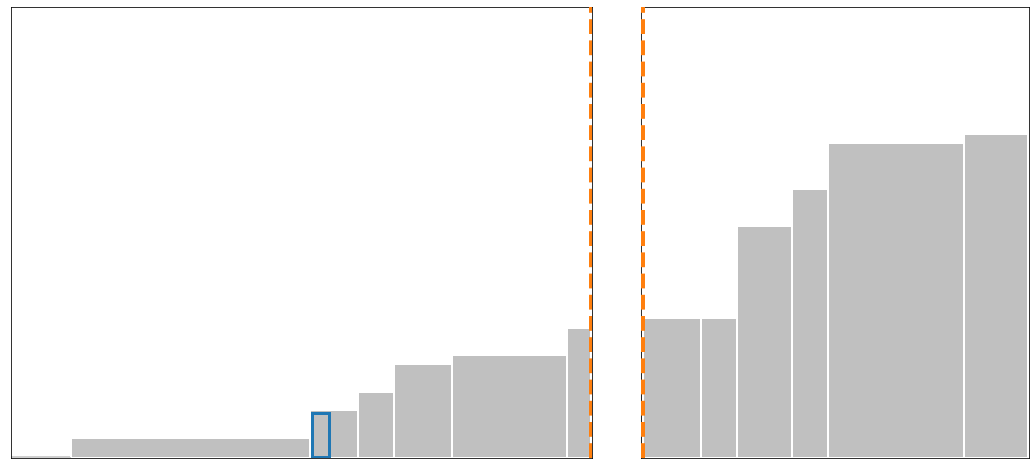

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,7), gridspec_kw={'width_ratios': [3, 2]})
fig.tight_layout()
ax[0].fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax[1].fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax[0].vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax[1].vlines(prjcts["Cumu Yield (afy)"], 0, 35000, color="white", linewidth=2, zorder=2)
ax[0].set_xlim([0,12130])
ax[1].set_xlim([11990,33350])
ax[0].set_ylim([-10,5600])
ax[1].set_ylim([-10,5600])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4,zorder=3)
ax[1].vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4,zorder=3)
ax[0].hlines(recycle,0, 1250, color="#C0C0C0", zorder=1)

# ReNeM 
ax[0].bar(x=6290, y=10, height=540.00, width=355, align="edge", ec='#1f77b4', fc="none", lw=3, zorder=4)

fig.savefig("Cost to agency of methods to address chronic overdraft in the Pajaro Valley_no labels.png")
fig.savefig("Cost to agency of methods to address chronic overdraft in the Pajaro Valley_no labels.pdf")

#### Labels

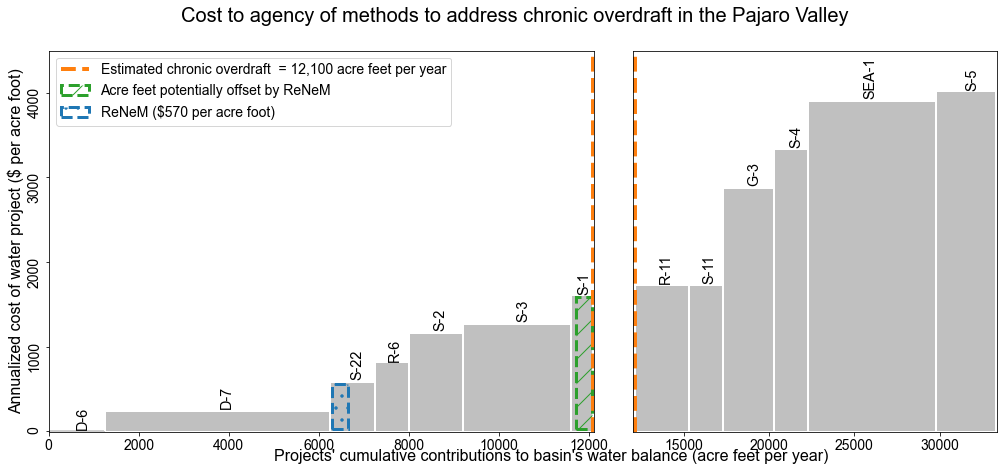

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,7), gridspec_kw={'width_ratios': [3, 2]}, sharex='col')
fig.tight_layout(pad=4, w_pad=.2)
ax[0].fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax[0].vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax[1].fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax[1].vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax[0].set_ylabel("Annualized cost of water project ($ per acre foot)", fontsize=16, rotation=90)
ax[0].tick_params(axis='y', labelrotation = 90)
ax[0].set_xlim([0,12130])
ax[1].set_xlim([11990,33350])
ax[0].set_ylim([-10,4500])
ax[1].set_ylim([-10,4500])

ax[0].text(5000, -350, r"Projects' cumulative contributions to basin's water balance (acre feet per year)", fontsize=16)
fig.suptitle('Cost to agency of methods to address chronic overdraft in the Pajaro Valley', fontsize=20)

ax[0].text(600, 50, r'D-6', fontsize="large", rotation=90)
ax[0].text(3800, 300, r'D-7', fontsize="large", rotation=90)
ax[0].text(6700, 640, r'S-22', fontsize="large", rotation=90)
ax[0].text(7550, 860, r'R-6', fontsize="large", rotation=90)
ax[0].text(8550, 1220, r'S-2', fontsize="large", rotation=90)
ax[0].text(10400, 1330, r'S-3', fontsize="large", rotation=90)
ax[0].text(11750, 1650, r'S-1', fontsize="large", rotation=90)
ax[1].text(13500, 1780, r'R-11', fontsize="large", rotation=90)
ax[1].text(16100, 1780, r'S-11', fontsize="large", rotation=90)
ax[1].text(18700, 2940, r'G-3', fontsize="large", rotation=90)
ax[1].text(21200, 3380, r'S-4', fontsize="large", rotation=90)
ax[1].text(25500, 3960, r'SEA-1', fontsize="large", rotation=90)
ax[1].text(31500, 4060, r'S-5', fontsize="large", rotation=90)

# ReNeM 
ax[0].bar(x=11725, y=30, height=1552.00, width=355, align="edge", linestyle = "dashed", hatch='/', ec='#2ca02c', fc="none", lw=3, zorder=4, label="Acre feet potentially offset by ReNeM")
ax[0].bar(x=6290, y=30, height=530.00, width=355, align="edge", linestyle = "dashed", hatch='.', ec='#1f77b4', fc="none", lw=3, zorder=4, label="ReNeM ($570 per acre foot)")

ax[0].vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4, label="Estimated chronic overdraft  = 12,100 acre feet per year", zorder=5)
ax[1].vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4, zorder=2)
ax[0].hlines(recycle,0, 1250, color="#C0C0C0", zorder=1)
ax[1].set_yticks([])

ax[0].legend(loc="upper left", fontsize = 14)

fig.savefig("Cost to agency of methods to address chronic overdraft in the Pajaro Valley_labeled.png", dpi=300)
fig.savefig("Cost to agency of methods to address chronic overdraft in the Pajaro Valley_labeled.pdf", dpi=300)

## Supplemental Information figures

#### ReNeM with agency paying baseline & TPC expenses 

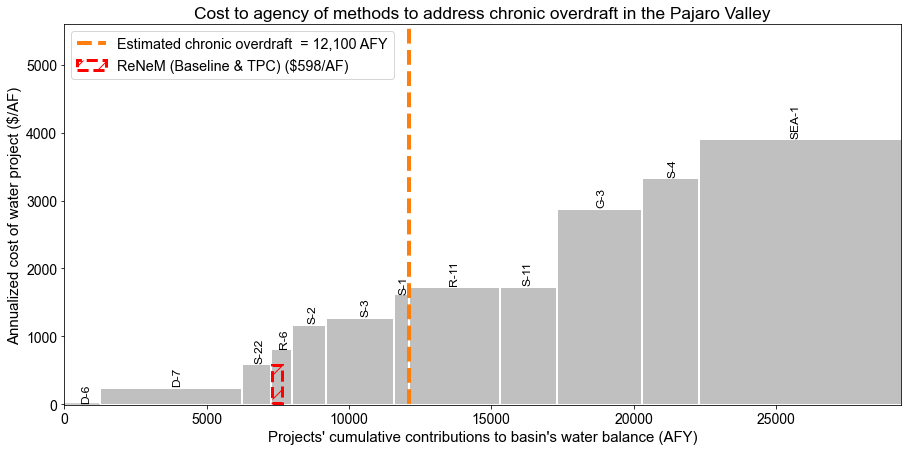

In [25]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax.vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax.set_xlabel("Projects' cumulative contributions to basin's water balance (AFY)", fontsize=15)
ax.set_ylabel("Annualized cost of water project ($/AF)", fontsize=15)
ax.set_title("Cost to agency of methods to address chronic overdraft in the Pajaro Valley", fontsize="x-large")
plt.xlim([0,29400])
plt.ylim([-10,5600])

plt.text(600, 50, r'D-6', fontsize="medium", rotation=90)
plt.text(3800, 300, r'D-7', fontsize="medium", rotation=90)
plt.text(6700, 640, r'S-22', fontsize="medium", rotation=90)
plt.text(7550, 860, r'R-6', fontsize="medium", rotation=90)
plt.text(8550, 1220, r'S-2', fontsize="medium", rotation=90)
plt.text(10400, 1330, r'S-3', fontsize="medium", rotation=90)
plt.text(11750, 1650, r'S-1', fontsize="medium", rotation=90)
plt.text(13500, 1780, r'R-11', fontsize="medium", rotation=90)
plt.text(16100, 1780, r'S-11', fontsize="medium", rotation=90)
plt.text(18700, 2940, r'G-3', fontsize="medium", rotation=90)
plt.text(21200, 3380, r'S-4', fontsize="medium", rotation=90)
plt.text(25500, 3960, r'SEA-1', fontsize="medium", rotation=90)

ax.vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4, label="Estimated chronic overdraft  = 12,100 AFY",zorder=3)
ax.hlines(recycle,0, 1250, color="#C0C0C0", zorder=1)

# ReNeM 
ax.bar(x=7290, y=10, height=568.00, width=355, align="edge", linestyle = "dashed", hatch='/', ec='red', fc="none", lw=3, zorder=4, label="ReNeM (Baseline & TPC) ($598/AF)")

ax.legend(loc="upper left", fontsize="large")

fig.savefig("SI_baseline & TPC_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.png")
fig.savefig("SI_baseline & TPC_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.pdf")

## ReNeM with agency paying baseline payment, TPC expenses externally funded

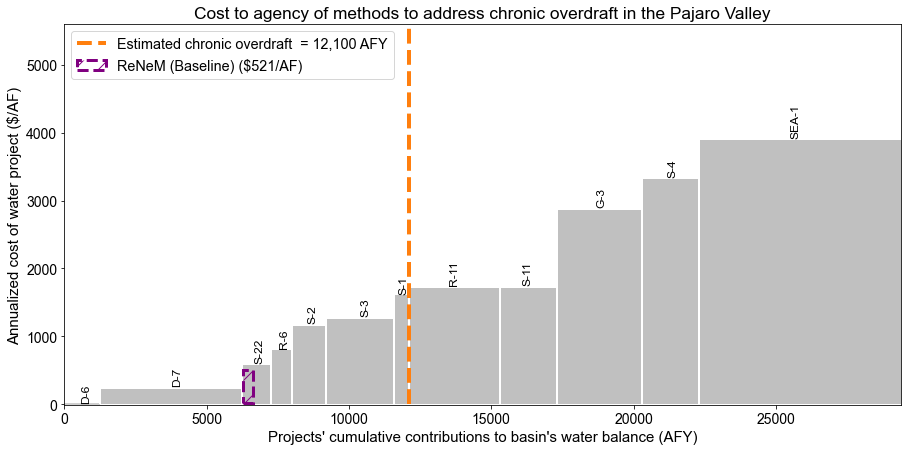

In [26]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax.vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax.set_xlabel("Projects' cumulative contributions to basin's water balance (AFY)", fontsize=15)
ax.set_ylabel("Annualized cost of water project ($/AF)", fontsize=15)
ax.set_title("Cost to agency of methods to address chronic overdraft in the Pajaro Valley", fontsize="x-large")
plt.xlim([0,29400])
plt.ylim([-10,5600])

plt.text(600, 50, r'D-6', fontsize="medium", rotation=90)
plt.text(3800, 300, r'D-7', fontsize="medium", rotation=90)
plt.text(6700, 640, r'S-22', fontsize="medium", rotation=90)
plt.text(7550, 860, r'R-6', fontsize="medium", rotation=90)
plt.text(8550, 1220, r'S-2', fontsize="medium", rotation=90)
plt.text(10400, 1330, r'S-3', fontsize="medium", rotation=90)
plt.text(11750, 1650, r'S-1', fontsize="medium", rotation=90)
plt.text(13500, 1780, r'R-11', fontsize="medium", rotation=90)
plt.text(16100, 1780, r'S-11', fontsize="medium", rotation=90)
plt.text(18700, 2940, r'G-3', fontsize="medium", rotation=90)
plt.text(21200, 3380, r'S-4', fontsize="medium", rotation=90)
plt.text(25500, 3960, r'SEA-1', fontsize="medium", rotation=90)

ax.vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4, label="Estimated chronic overdraft  = 12,100 AFY",zorder=3)
ax.hlines(recycle,0, 1250, color="#C0C0C0", zorder=1)

# ReNeM 
ax.bar(x=6290, y=10, height=491.00, width=355, align="edge", linestyle = "dashed", hatch='/', ec='purple', fc="none", lw=3, zorder=4, label="ReNeM (Baseline) ($521/AF)")

ax.legend(loc="upper left", fontsize="large")

fig.savefig("SI_baseline but no TPC_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.png")
fig.savefig("SI_baseline but no TPC_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.pdf")

#### ReNeM without baseline payment, TPC expenses externally funded

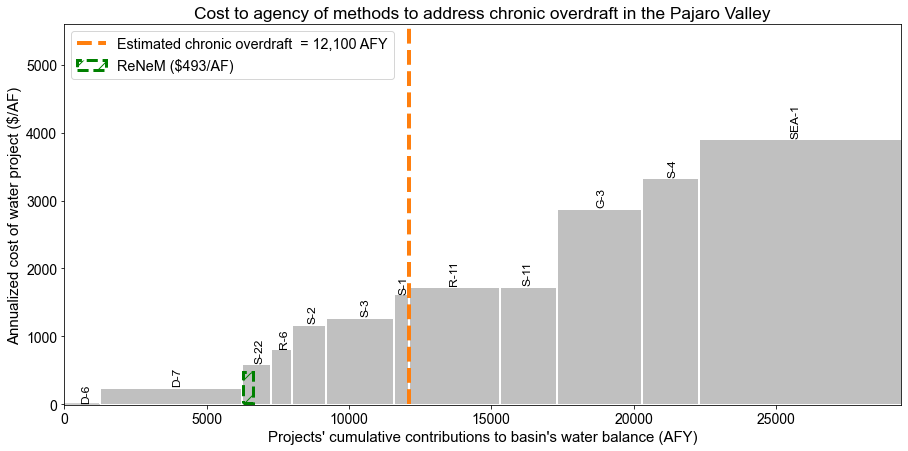

In [27]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.fill_between(prjcts["Cumu Yield (afy)"], 0, prjcts["Planning Cost ($/af)"], alpha=1, linewidth=0, step="pre",
                color="#C0C0C0", zorder=1)
ax.vlines(prjcts["Cumu Yield (afy)"], 0, 23000, color="white", linewidth=2, zorder=2)
ax.set_xlabel("Projects' cumulative contributions to basin's water balance (AFY)", fontsize=15)
ax.set_ylabel("Annualized cost of water project ($/AF)", fontsize=15)
ax.set_title("Cost to agency of methods to address chronic overdraft in the Pajaro Valley", fontsize="x-large")
plt.xlim([0,29400])
plt.ylim([-10,5600])

plt.text(600, 50, r'D-6', fontsize="medium", rotation=90)
plt.text(3800, 300, r'D-7', fontsize="medium", rotation=90)
plt.text(6700, 640, r'S-22', fontsize="medium", rotation=90)
plt.text(7550, 860, r'R-6', fontsize="medium", rotation=90)
plt.text(8550, 1220, r'S-2', fontsize="medium", rotation=90)
plt.text(10400, 1330, r'S-3', fontsize="medium", rotation=90)
plt.text(11750, 1650, r'S-1', fontsize="medium", rotation=90)
plt.text(13500, 1780, r'R-11', fontsize="medium", rotation=90)
plt.text(16100, 1780, r'S-11', fontsize="medium", rotation=90)
plt.text(18700, 2940, r'G-3', fontsize="medium", rotation=90)
plt.text(21200, 3380, r'S-4', fontsize="medium", rotation=90)
plt.text(25500, 3960, r'SEA-1', fontsize="medium", rotation=90)

ax.vlines(overdraft_threshold,-5, 5650, color="#ff7f0e",linestyle = "dashed", linewidths=4, label="Estimated chronic overdraft  = 12,100 AFY",zorder=3)
ax.hlines(recycle,0, 1250, color="#C0C0C0", zorder=1)

# ReNeM 
ax.bar(x=6290, y=10, height=463.00, width=355, align="edge", linestyle = "dashed", hatch='/', ec='green', fc="none", lw=3, zorder=4, label="ReNeM ($493/AF)")

ax.legend(loc="upper left", fontsize="large")

fig.savefig("SI_no TPC or baseline_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.png")
fig.savefig("SI_no TPC or baseline_Cost to agency of methods to address chronic overdraft in the Pajaro Valley.pdf")